# Bayesian Data Analysis 2019 - Data Analysis Project Report

## Loaded packages

Below are the loaded packages that are used in the project

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

## Load the data

Below we load the data from our csv file. This file is accessible at https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume 

We also take the first look at the data

In [2]:
# load data

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


There are many labelled data columns in our data. Below we can see the holiday, weather main and weather description labels.

In [4]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Martin Luther King Jr Day        6
New Years Day                    6
Christmas Day                    6
Columbus Day                     5
State Fair                       5
Veterans Day                     5
Memorial Day                     5
Washingtons Birthday             5
Independence Day                 5
Name: holiday, dtype: int64

In [5]:
df['weather_main'].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [6]:
df['weather_description'].value_counts()

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

Let's look at the data that we have in quantified form. First the traffic volume. This data seems good. There are no clear outliers.

Text(0.5, 1.0, 'Traffic volume')

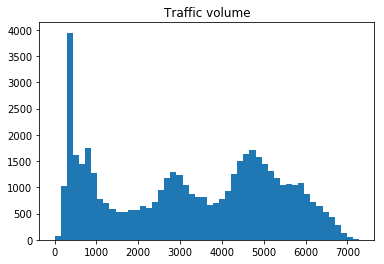

In [7]:
plt.hist(df['traffic_volume'], bins=50)
plt.title("Traffic volume")

From the temperature data we can see that there are clear outliers. The x-axel is scaled from 0 to 300 even though there are barely any values below 250. When we dig deeper below the 250 values, we can see there are a couple of really low values. 

Text(0.5, 1.0, 'Temperature')

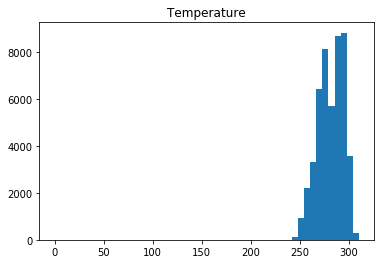

In [8]:
plt.hist(df['temp'], bins=50)
plt.title("Temperature")

Text(0.5, 1.0, 'Low temperatures')

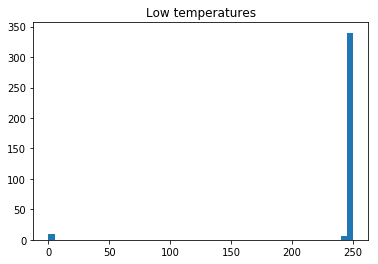

In [40]:
df_low_temp = df[df['temp'] < 250]
plt.hist(df_low_temp['temp'], bins=50)
plt.title("Low temperatures")

In [41]:
df[df['temp'] == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


When we look at these zero Kelvin temperatures, we can see that the observations seem otherwise correct. The sky is clear, there is no rain or snow, and there are some small amounts of traffic during that time. Thus, we suggest that these datapoints only lack the temperature data and can still be used. We will fix the points by taking the average temperature during similar times (Jan-Feb nights).

Next off is the rain. We can see again that there are some outliers. When we take the description of our data, we see there is a datapoint with around 9831 mm of rain. Otherwise, the data seems reasonable. There are some 50mm rain points, but this is still realistic within one hour of really heavy rain. We will set the 9831mm datapoint to an average of our very heavy rain weather descriptions

Text(0.5, 1.0, 'Rain')

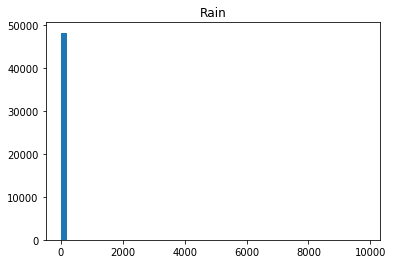

In [8]:
plt.hist(df['rain_1h'], bins=50)
plt.title("Rain")

In [50]:
df[df['weather_description'] == 'very heavy rain']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
7133,None,291.76,16.38,0.0,76,Rain,very heavy rain,2013-06-22 05:00:00,635
7179,None,295.82,44.45,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802
7664,None,292.82,19.90,0.0,20,Rain,very heavy rain,2013-07-14 05:00:00,542
7667,None,292.65,25.32,0.0,8,Rain,very heavy rain,2013-07-14 06:00:00,958
7670,None,292.87,21.42,0.0,90,Rain,very heavy rain,2013-07-14 07:00:00,1745
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
10734,None,262.65,18.80,0.0,64,Rain,very heavy rain,2013-12-16 19:00:00,2755
10806,None,264.50,28.70,0.0,64,Rain,very heavy rain,2013-12-19 23:00:00,1190
14853,None,298.21,18.03,0.0,0,Rain,very heavy rain,2014-06-02 16:00:00,6443
16300,None,294.87,23.80,0.0,90,Rain,very heavy rain,2015-07-06 03:00:00,346


Text(0.5, 1.0, 'Corrected rain')

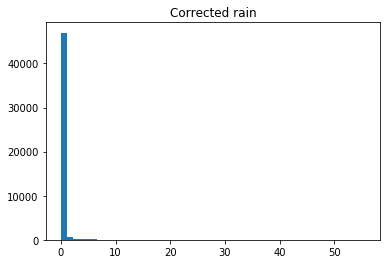

In [51]:
df_rain = df[df['rain_1h'] < 9831]
plt.hist(df_rain['rain_1h'], bins=50)
plt.title("Corrected rain")

With snow and clouds, the data seems to be correct. There are a lot of datapoints with 0 snow, but there are also a lot of points where there are similar looking numbers of snow. With clouds, the data is quite dispersed.

Text(0.5, 1.0, 'Snow')

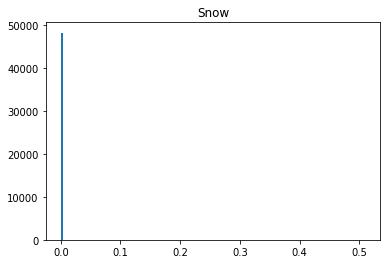

In [54]:
plt.hist(df['snow_1h'], bins=150)
plt.title("Snow")

Text(0.5, 1.0, 'Clouds')

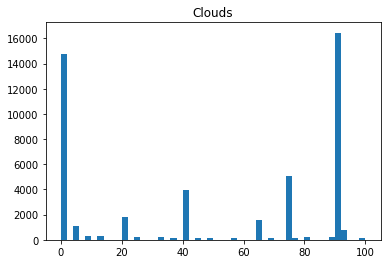

In [10]:
plt.hist(df['clouds_all'], bins=50)
plt.title("Clouds")

Text(0.5, 1.0, 'Traffic at 12:00')

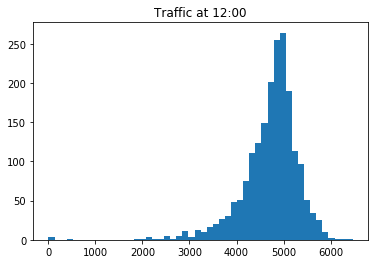

In [24]:
# daytime-specific traffic data:
import datetime

# convert date_time-field into datetime format & add index
df_with_dates = df
df_with_dates['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df_with_dates = df_with_dates.set_index('date_time')

df_with_dates['weekday'] = df_with_dates.index.dayofweek
df_with_dates

plt.hist(df_with_dates.between_time('11:45','12:15')['traffic_volume'], bins=50)
plt.title("Traffic at 12:00")

# Including source code

In general, all code needed to produce the essential parts needs to be included, so that it is possible to see, for peer reviewers, where errors may have happened

You can always look at the open rubrics to see how and what is asked for in each exercise.

Try to avoid printing an excessive amount of code and think about what is essential for showing how did you get the result.

Write clear code. The code is also part of your report and clarity of the report affects your score. If the code is not self-explanatory, add comments. In a notebook, you can interleave explaining text and code.

If in doubt additional source code can be included in an appendix. 

# Format instructions

All exercises in the assignment should start with header 1 fully specifying that it is exercise X, as:

# Exercise 1)
## a)

Subtasks in each assignments should be numbered and use header 2 (two ##). 

We can easily add R code as chunks in the following way:

In [ ]:
1+1

# Plots

Include plots, where we can specify the width and height of the figure.


# Equations

Equations should be correctly formated using LaTeX or being included as images if, for example, Microsoft Equations is used. 

In Markdown, equations can easily be formulated using LaTeX in line as $f(k) = {n \choose k} p^{k} (1-p)^{n-k}$ or use the math environment as follows:

$$\begin{array}{ccc}
x_{11} & x_{12} & x_{13}\\
x_{21} & x_{22} & x_{23}
\end{array}$$

If you are new to LaTeX equations, you could use the [latext4technics](https://www.latex4technics.com/) equation editor to create LaTeX equations to include in the report.

More information on using LaTeX in R markdown can be found in 2.5.3 in [R Markdown: The Definite Guide](https://bookdown.org/yihui/rmarkdown/).

A short introduction to equations in LaTeX can be found [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).

# Language

The language used in the course is English. Hence the report needs to be written in English.

# Jupyter Notebook and other report formats
You are allowed to use any format to produce your report, such as Jupyter Notebook, as long as you obide by the instructions in this 

template.